# Library import

In [4]:
from graph_processing import get_item_dict_from_xml, create_graph_from_dict, create_data_sequences
from data_preprocessing import multi_timeseries_uniformization
from undermine_query import get_item_timeseries
from data_preprocessing import preprocess_timeseries, multi_timeseries_preprocessing
from torch_geometric.utils.convert import from_networkx
from graph_model import STGCN, train_model
import numpy as np
from graph_model import train_model
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

## Graph initialization

In [5]:
item_dict = get_item_dict_from_xml()
graph = create_graph_from_dict(item_dict, min_level = 110)

## Visualization of Graph

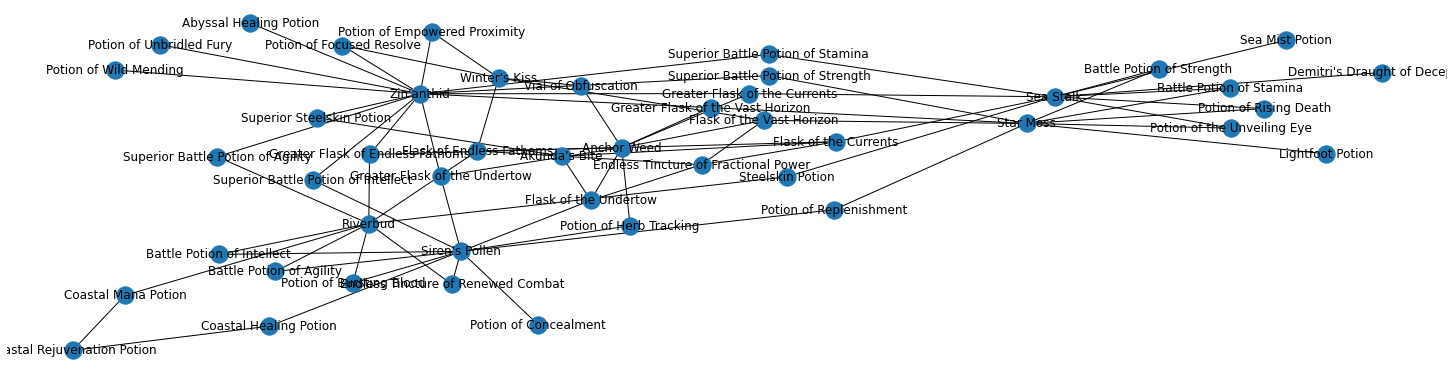

In [6]:
pos = nx.spring_layout(graph, scale =20)
labels= nx.get_node_attributes(graph,'name')
plt.figure(figsize = (20, 5))
nx.draw(graph, pos, with_labels=False)
nx.draw_networkx_labels(graph, pos, labels)
plt.show()

TODO:
- Aggrandir le Dataset en comptant plusieurs royaumes et en faisant une étude par cluster pour être certain de l'hypothèse.
- Entraîner le modèle par graphe
- Ajouter la sortie des patches
- 2 entraînement (global - local ?)

## Creates train dataset.
Get Data from Outland as training set and pre-process it

In [ ]:
# List of realms : https://www.wowprogress.com/realms/rank/eu/lang.en
# train_realms = ['outland', 'draenor', 'silvermoon', 'kazzak', 'ravencrest', 'ragnaros', 'stormscale']
# test_realms = ['sylvanas']

# train_dataset = []
# Get Data from all train realms
# for realm in tqdm(train_realms):
    # individual_dfs = get_all_df_from_graph(graph, slug = '"{}"'.format(realm), region = '"EU"')
    # merged_df = multi_timeseries_uniformization(individual_dfs, ['pricestart'])
    # processed_merged_df = multi_timeseries_preprocessing(merged_df)
    # dataset = create_data_sequences(processed_merged_df, graph, tw)
    # train_dataset.extend(dataset)

In [16]:
# all_dfs = get_all_df_from_graph(graph, slug = '"outland"', region = '"EU"')
# merged_df = multi_timeseries_uniformization(all_dfs, ['pricestart'])

# merged_df = pd.read_csv('merged_df.csv')
# merged_df.index = pd.to_datetime(merged_df['when'])
# merged_df = merged_df.drop('when', axis = 1)

# tw = 13
# dataset = create_data_sequences(processed_merged_df, graph, tw)

### Model creation and training

We create a graph model here and train it on the Outland dataset.

In [40]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TAGConv
import torch.nn as nn

def train_model(model, dataset, epochs = 100, lr=0.001):
    """
    Uses naive form of dataset to train a Graph model.
    """
    from torch_geometric.data import DataLoader
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    for i in range(epochs):
        for batch in loader:
            optimizer.zero_grad()
            y_pred = model(batch)
            labels = batch.labels
            
            single_loss = loss_function(y_pred.y, labels)
            single_loss.backward()
            optimizer.step()

        if i%3 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return model

In [42]:
epochs = 25
dimension = 2
tw = 13 
model = STGCN(tw, len(graph.nodes), dimension, time_conv_length=4).cuda()
model = train_model(model, dataset, epochs=50, lr=0.001)

epoch:   1 loss: 0.01961884
epoch:   4 loss: 0.02598925
epoch:   7 loss: 0.01830107
epoch:  10 loss: 0.04004167


KeyboardInterrupt: 

## Creates a test set.

Gets data from the doomhammer realm to test the model.

In [34]:
# all_dfs_doomhammer = get_all_df_from_graph(graph, slug = '"doomhammer"', region = '"EU"')
# merged_df_doomhammer = multi_timeseries_uniformization(all_dfs_doomhammer, ['pricestart'])
# merged_df_doomhammer.to_csv('merged_df_doomhammer.csv')

# processed_merged_df_doomhammer = multi_timeseries_preprocessing(merged_df_doomhammer)
# dataset_doomhammer = create_data_sequences(processed_merged_df_doomhammer, graph, tw)

In [39]:
# Test
model.eval()
import torch

y_truth = []
y_pred = []
with torch.no_grad():
    for data, labels in dataset_doomhammer:
        y_truth.append(labels.cpu().numpy().flatten())
        y_pred.append(model(data).y.cpu().numpy().flatten())

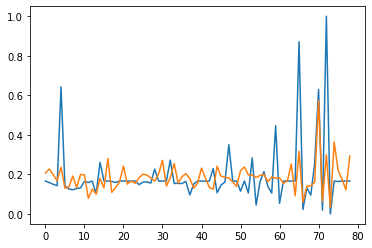

In [47]:
test_index = 33

plt.plot(np.array(y_truth)[:,test_index])
plt.plot(np.array(y_pred)[:,test_index])

In [27]:
dataset = UndermineDataset(root = 'data/', graph = graph, tw=13)

Processing...
delete node 152634
delete node 152636
delete node 165721
delete node 165744
Done!


In [32]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [33]:
for batch in loader:
    print(batch)
    break

Batch(batch=[42], edge_index=[2, 150], labels=[42, 2], x=[42, 2, 13])
